## Model for myelin plasticity

We are delaing with a network of interacting populations of neurons. The time evolution of the firing rate of the population $i$ can be expressed as:

$$\frac{d}{dt}r_i(t)=-r_i(t)+\frac{1}{N}\sum_{j=1}^N r_j(t)\gamma_{ij} w_{ij}+r'_i $$

The coincidence factor penalizes heterogeneous distributions of delays:

$$\gamma_{ij}=exp \Bigg[- \frac{\kappa}{2} \sum_{k=1}^N (\tau_{ij}-\tau_{kj})^2 \Bigg]$$ 

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import random
import scipy
from scipy import stats
from scipy.stats import randint, poisson
from scipy.stats import norm
import seaborn as sns
import networkx as nx
from scipy.spatial import distance
from tqdm.notebook import tqdm 

The following data comes from:
http://umcd.humanconnectomeproject.org/ 

- 68 Regions of Interest (cortical areas)

- Study Name: ICBM

- Imaging Modality: DTI

- Scan Parameters: Diffusion directions=30, B value=800

- Healty individuals 

- Age Range 18-90

- Gender: Mixed

- Subject Pool: ICBM normal subjects

- Group Size: 138

In [2]:
#ROIs names
Name = []
foldername = os.path.join(os.getcwd(), 'data', 'matrices', 'ICBM')
filename = os.path.join(foldername, 'freesurfer_regions_68_sort_full.txt')
name_file = open(filename, 'r')
for line in name_file.readlines():
    Name.append([line])
    for i in line.split(","):
        Name[-1].append(i)
Name=np.array(Name)
Name=Name[:,0]
for i in range(len(Name)):
    Name[i]=Name[i].rstrip() 
name_df=pd.DataFrame({'node name' : Name})
name_df

,node name
0,lh_bankssts
1,lh_caudalanteriorcingulate
2,lh_caudalmiddlefrontal
3,lh_cuneus
4,lh_entorhinal
5,lh_fusiform
6,lh_inferiorparietal
7,lh_inferiortemporal
8,lh_isthmuscingulate
9,lh_lateraloccipital


In [3]:
#P=nodes positions (3D coordinates)
filename = os.path.join(foldername, 'fs_region_centers_68_sort.txt')
P = np.loadtxt(fname = filename)

pos_df=pd.DataFrame({'node name' : Name,
'x': P[:,0],
'y': P[:,1],
'z': P[:,2]                       
})
pos_df.set_index('node name')

,x,y,z
node name,,,
lh_bankssts,-56.452962,-47.393728,3.289199
lh_caudalanteriorcingulate,-4.660000,21.070000,29.770000
lh_caudalmiddlefrontal,-37.267652,6.311987,47.789819
lh_cuneus,-4.574468,-85.354610,10.134752
lh_entorhinal,-24.254072,-1.517915,-29.726384
lh_fusiform,-37.223154,-36.582215,-25.417785
lh_inferiorparietal,-37.027027,-74.962838,29.641892
lh_inferiortemporal,-51.318940,-24.107949,-26.985280
lh_isthmuscingulate,-5.688406,-48.355072,14.202899


In [4]:
N=len(P)
N

68

In [5]:
#we need 2D coordinates for 2D plots
Pxy=P[0:len(P),0:2]
Pyz=P[0:len(P),1:3]
Pxz=P[0:len(P),0:3:2]

In [6]:
#M=Connectivity matrix
filename = os.path.join(foldername, 'icbm_fiber_mat.txt')
M = np.loadtxt(fname = filename)
M = pd.DataFrame(M, dtype='float64')

In [7]:
M=np.array(M)
for i in range(len(M)):
    for j in range(len(M)):
        if M[i,j]<0.0002:
            M[i,j]=0
M=pd.DataFrame(M)

In [8]:
#compute eucledian distance between points in 3d space
axonal=distance.cdist(P,P,'euclidean')
axonal=pd.DataFrame(axonal, dtype='float64')

#eliminate zero weights from connectivity matrix in the axonal lengths matrix
boolM = (M > 0).astype('float64')
axonal = axonal * boolM
# for i in range(len(M)):
#     for j in range(len(M)):
#         if M[i][j]==0:
#             axonal[i][j]=0

Text(0.5,1,'Axonal lengths (mm)')

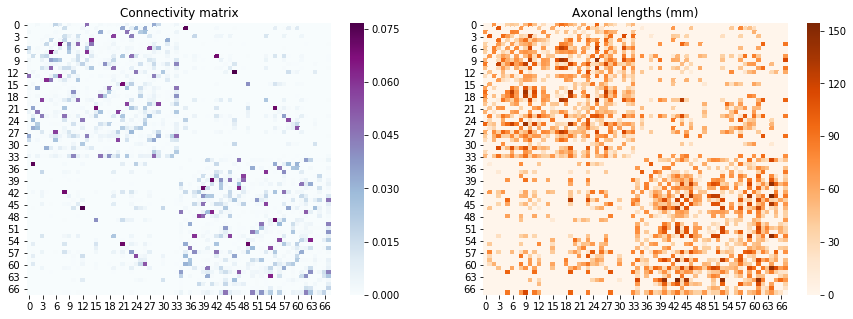

In [9]:
#display connectivity and axonal length matrices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
sns.heatmap(ax = ax1, data = M, cmap="BuPu")
sns.heatmap(ax = ax2, data = axonal, cmap="Oranges")
ax1.set_title('Connectivity matrix')
ax2.set_title('Axonal lengths (mm)')

In [ ]:
import time

#binary connectivity matrix
def weighted_to_binary(L):
    d=L.shape[0]
    L2=np.zeros((d,d))
    for i in range(d):
          for j in range(d):      
            if L[i,j] != 0:
                L2[i,j]=1
    return(L2)

start1 = time.time()
MB = (M > 0)
MB = pd.DataFrame(MB, dtype='float64')
end1 = time.time()

start2 = time.time()
MB=weighted_to_binary(np.array(M))
end2 = time.time()

print(end1 - start1)
print(end2 - start2)

### Let's start by setting constant velocities = 3 m/s and look at the changes operated by myelin plasticity

In [11]:
velocity=np.ones((N,N),dtype='float64')*3

In [12]:
delays=axonal/velocity   #the original delays

In [13]:
np.array(delays).min(), np.array(delays).max(), np.array(delays).mean(), np.array(delays).std()

(0.0, 51.43342980504136, 7.4065226986983985, 11.151965887046517)

### Algorithm

The process we are trying to model is typically more slower than the dynamics, then we refer to the steady state of the network $$r_i=\frac{1}{N}\sum_{j=1}^N r_j\gamma_{ij} w_{ij} + r'_i $$


Let's define an objective function and try to maximize it when updating the delay term: $$\tau_{ij}^{T+1}=\tau_{ij}^T + c \frac{d}{\tau_{ij}}E(r),$$ and interpret the learning rate c as the myelination rate. 

The objective function is 
$$E(r)= \frac{1}{2}\sum_{k=1}^N r_k^2$$ and we try to maximize it, with gradient ascent.

##### Compute the learning rule:
$$\tau_{ij}^{T+1}=\tau_{ij}^T + \eta \frac{d}{\tau_{ij}}L(r)=\tau_{ij}^T - \frac{1}{N} \eta \ \kappa \ r_i r_j w_{ij} \gamma_{ij} \Bigg[\sum_{h=1}^N (\tau_{ij}-\tau_{hj}) \Bigg]$$

In [14]:
#in the coincidence factor we take into account only nonzero delays 
def H(p):
    if p<=0:
        return(0)
    else:
        return(1)

In [15]:
eps=0.0005
#define the coincidence factors, collected in a matrix
def G(de):
    gamma=np.zeros((N,N),dtype='float64')
    for i in range(N):
            for j in range(N):
                s=0  #only when a connection exists
                for k in range(N):
                    s=s+((de[i][j]-de[k][j])**2)*H(de[k][j]) # No need for H(de[i][j]) here.
                    
                gamma[i,j]= np.exp(-s*eps/2)#*MB[i][j]          

    return(gamma)

In [16]:
gg=G(delays)
pd.DataFrame(gg,dtype='float64')

,0,1,2,3,4,5,6,7,8,9,...,58,59,60,61,62,63,64,65,66,67
0,0.143236,0.230131,0.747143,0.067934,0.075164,0.436177,0.343711,0.588713,0.032202,0.271339,...,0.160731,0.006168,0.047000,0.001094,0.016089,0.234244,0.006153,0.057223,0.392345,0.010837
1,0.143236,0.230131,0.250468,0.090176,0.075164,0.046047,0.021938,0.088972,0.496197,0.003288,...,0.537847,0.289240,0.328601,0.001094,0.016089,0.234244,0.006153,0.057223,0.392345,0.010837
2,0.662439,0.230131,0.250468,0.067934,0.075164,0.046047,0.490199,0.509774,0.032202,0.003288,...,0.160731,0.006168,0.744396,0.001094,0.016089,0.234244,0.006153,0.057223,0.392345,0.010837
3,0.143236,0.151880,0.250468,0.067934,0.355928,0.655011,0.300373,0.088972,0.460034,0.065811,...,0.160731,0.006168,0.047000,0.196693,0.016089,0.234244,0.006153,0.057223,0.392345,0.010837
4,0.143236,0.230131,0.250468,0.195365,0.075164,0.458494,0.021938,0.541272,0.556386,0.294737,...,0.160731,0.006168,0.047000,0.001094,0.016089,0.234244,0.006153,0.057223,0.392345,0.010837
5,0.637613,0.230131,0.250468,0.461392,0.519705,0.046047,0.552824,0.284741,0.625824,0.333725,...,0.160731,0.006168,0.047000,0.001094,0.169133,0.234244,0.006153,0.057223,0.392345,0.214273
6,0.715471,0.230131,0.603024,0.424581,0.075164,0.664711,0.021938,0.578656,0.032202,0.137232,...,0.160731,0.006168,0.047000,0.341003,0.016089,0.234244,0.006153,0.057223,0.392345,0.010837
7,0.667810,0.230131,0.622345,0.067934,0.485696,0.188458,0.532932,0.088972,0.565659,0.407326,...,0.160731,0.006168,0.047000,0.001094,0.016089,0.234244,0.006153,0.057223,0.392345,0.010837
8,0.143236,0.608404,0.250468,0.405356,0.706883,0.642669,0.021938,0.710280,0.032202,0.263312,...,0.236814,0.006168,0.421225,0.166001,0.016089,0.234244,0.006153,0.057223,0.392345,0.488258
9,0.775697,0.230131,0.250468,0.310837,0.388604,0.679414,0.292877,0.627466,0.623574,0.003288,...,0.160731,0.006168,0.047000,0.359937,0.016089,0.234244,0.006153,0.057223,0.392345,0.018792


In [17]:
np.array(gg).min(), np.array(gg).max(), np.array(gg).mean(), np.array(gg).std()

(0.0008216299264720995,
 0.9071435839014439,
 0.23550122135701954,
 0.22749400031550027)

In [18]:
#define the coincidence factors, collected in a matrix
def diff(de):
    diff=np.zeros((N,N),dtype='float64')
    for i in range(N):
            for j in range(N):
                s=0  
                for k in range(N):
                    
                    s=s+(de[i][j]-de[k][j])*H(de[i][j])*H(de[k][j])
                              
                diff[i,j]=s*MB[i][j]

    return(diff)

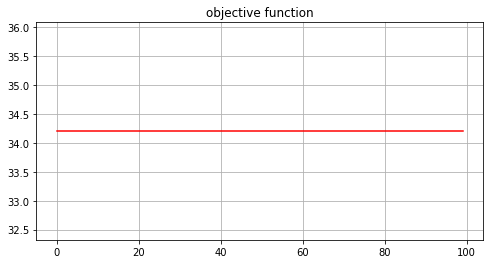

In [19]:
#compute the desired output
D=np.ones((N,N))*10

r_0=np.ones(N)                                   #baseline firing rate

R=[]

v=axonal/D 
g=G(D)
A = np.identity(N,dtype='float64')-(1/N)*(g*MB*(M))   
r = np.linalg.solve(A, r_0)
R.append(r)
RR=np.fromfunction(lambda i, j: r[i]*r[j], (N, N), dtype=int)
p=np.array(g*M,dtype='float64')  
C=0.9
D=D-C*p*diff(D)*RR*(1/N)*eps 

R1=np.transpose(R)
cost=np.zeros(len(R1.T))

for i in range(len(R1)): 
    R2=R1[i]**2
    cost=cost+R2
    
cost=cost/2

des=np.ones(100)*cost
  
plt.figure(figsize=(8,4))
plt.plot(des, 'r')
plt.title('objective function')
plt.grid(True)

In [20]:
time=range(6000)        #12 

In [21]:
D=np.array(axonal/velocity,dtype='float64')

r_0=np.ones(N)                                   #baseline firing rate

R=[]

for t in tqdm(time):
    
    v=axonal/D
    v=v.fillna(0)
    if np.min(D)>=0 and np.max(np.array(v))<100:
        g=G(D)        
  
    
        A = np.identity(N,dtype='float64')-(1/N)*(g*MB*(M))   
        r = np.linalg.solve(A, r_0)
    
        R.append(r)
    
        RR=np.fromfunction(lambda i, j: r[i]*r[j], (N, N), dtype=int)
    
        p=np.array(g*M,dtype='float64')  
        

        C=0.1/eps  #what is the optimal learning rate C? maybe a variable C is better!

        
        D=D-C*p*diff(D)*RR*(1/N)*eps 
    else:
        print(t)
        break      

  0%|          | 0/6000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
#plot the objective function, that has to be increasing
R1=np.transpose(R)
cost=np.zeros(len(R1.T))

for i in range(len(R1)): 
    R2=R1[i]**2
    cost=cost+R2
    
cost=cost/2

maximal=des[0]*np.ones(len(cost))
  
plt.figure(figsize=(8,4))
plt.plot(cost, label='objective function')
plt.plot(maximal, 'r', label='maximal objective function')
plt.title('objective function')
plt.xlabel('iterations')
#plt.ylabel('')
plt.legend()
plt.grid(True)

In [ ]:
cost[-1]==cost[-2]

In [ ]:
#some statistics before and after the algorithm
np.mean(gg),np.mean(g), np.mean(gg)<np.mean(g)

In [ ]:
np.array(delays).std()**2, np.array(D).std()**2, np.array(delays).std()**2>np.array(D).std()**2

In [ ]:
#velocities adjusted by myelin
velocity2=axonal/D
velocity2=velocity2.fillna(0)

In [ ]:
np.array(velocity2).max()

In [ ]:
np.array(velocity2).min()

In [ ]:
np.array(velocity2).mean()

In [ ]:
np.array(delays).max(), np.array(D).max()

In [ ]:
np.array(delays).mean(), np.array(D).mean()

In [ ]:
np.array(delays).std(), np.array(D).std()

In [ ]:
#plot delays matrices
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25,5))
sns.heatmap(ax = ax1, data = delays, cmap="PiYG")
sns.heatmap(ax = ax2, data = D, cmap="PiYG")
sns.heatmap(ax = ax3, data = np.array(D==delays), cmap="PiYG")
ax1.set_title('Starting delays (ms)')
ax2.set_title('Updated delays (ms)')
ax3.set_title('Where they differ? (boolean values, 0=differ)')

In [ ]:
v=0
V=np.array(D).max() 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
sns.heatmap(ax = ax1, data = delays, vmin=v, vmax=V, cmap="PiYG")
sns.heatmap(ax = ax2, data = D, vmin=v, vmax=V, cmap="PiYG")
ax1.set_title('Starting delays (ms)')
ax2.set_title('Updated delays (ms)')

In [ ]:
#plot velocities matrices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
v=0
V=np.array(velocity2).max()
sns.heatmap(ax = ax1, data = velocity*MB, vmin=v, vmax=V, cmap="gist_ncar")
sns.heatmap(ax = ax2, data = velocity2*MB, vmin=v, vmax=V, cmap="gist_ncar")
ax1.set_title('Starting velocities (m/s)')
ax2.set_title('Updated velocities (m/s)')

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
g2=G(D)
v=0
V=(np.array(g2)).max()
sns.heatmap(ax = ax1, data = gg, vmin=v, vmax=V, cmap="YlGnBu")
sns.heatmap(ax = ax2, data = g2, vmin=v, vmax=V, cmap="YlGnBu")  #YlGnBu GnBu YlOrRd
ax1.set_title('Starting gamma')
ax2.set_title('Updated gamma')

In [ ]:
gamma1=[]
gamma2=[]

g2=G(D)

for i in range(N):
    for j in range(N):
        if M[i][j]!=0:
            gamma1.append(gg[i][j])
            gamma2.append(g2[i][j])
np.mean(gamma1), np.std(gamma1)**2, np.mean(gamma2), np.std(gamma2)**2

In [ ]:
#display velocity and axonal length matrices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
sns.heatmap(ax = ax1, data = axonal, cmap="RdBu")
sns.heatmap(ax = ax2, data = velocity2, cmap="RdBu")
ax1.set_title('Axonal lengths (mm)')
ax2.set_title('Updated velocities (m/s)')

In [ ]:
#what is the difference between the two? (normalizaed matrices)
diff_vel_axo = np.abs(velocity2/np.max(velocity2) - axonal/np.max(axonal))
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25,5))
sns.heatmap(ax = ax1, data = velocity2/np.max(velocity2), cmap="RdBu")
sns.heatmap(ax = ax2, data = axonal/np.max(axonal), cmap="RdBu")
sns.heatmap(ax = ax3, data = diff_vel_axo, cmap="RdBu")
ax1.set_title('Axonal lengths (mm)')
ax2.set_title('Updated velocities (m/s)')
ax3.set_title('difference')

In [ ]:
#distance/similarity between two matrices: Frobenius distance
frob1=np.linalg.norm(velocity/np.max(velocity) - axonal/np.max(axonal))
frob2=np.linalg.norm(velocity2/np.max(velocity2) - axonal/np.max(axonal))
frob1, frob2

In [ ]:
#prepare histograms
histv1=[]
histv2=[]
histd1=[]
histd2=[]
hista=[]

for i in range(N):
    for j in range(N):
        if axonal[i][j]!=0:
            histv1.append(velocity[i][j])
            histv2.append(velocity2[i][j])
            histd1.append(delays[i][j])
            histd2.append(D[i][j])
            hista.append(axonal[i][j])           

In [ ]:
np.mean(histv1), np.mean(histv2), np.mean(histd1), np.mean(histd2)

In [ ]:
np.std(histv1)**2, np.std(histv2)**2, np.std(histd1)**2, np.std(histd2)**2

In [ ]:
fig, axs = plt.subplots(2, 2, tight_layout=True, figsize=(15,10))

n=100

axs[0][0].hist(histv1, bins=n, density=True)
axs[0][1].hist(histv2, bins=n, density=True)
axs[1][0].hist(histd1, bins=n, density=True)
axs[1][1].hist(histd2, bins=n, density=True)

axs[0][0].set_title('starting velocities')
axs[0][1].set_title('updated velocities')
axs[1][0].set_title('starting delays')
axs[1][1].set_title('updated delays')

axs[0][0].set_xlabel('velocity (m/s)')
axs[0][1].set_xlabel('velocity (m/s)')
axs[1][0].set_xlabel('time delay (ms)')
axs[1][1].set_xlabel('time delay (ms)')

In [ ]:
from scipy.stats import pearsonr
pearsonr(histv2,hista)

In [ ]:
plt.figure(figsize=(10,7))
plt.scatter(hista, histv2, c='blue', marker='.')
plt.title('correlation between velocities and axonal lengths')
plt.ylabel('velocity (m/s)')
plt.xlabel('axonal length (mm)')

In [ ]:
fig, axs = plt.subplots(1, 2, tight_layout=True, figsize=(12,5))

n=100

axs[0].hist(histv1[:400], bins=n)
axs[0].hist(histv2, bins=n)
axs[1].hist(histd1, bins=n)
axs[1].hist(histd2, bins=n)

axs[0].set_title('velocities')
axs[1].set_title('delays')

axs[0].set_xlabel('velocity (m/s)')
axs[1].set_xlabel('time delay (ms)')

axs[0].set_ylabel('frequencies')

axs[0].legend(['starting velocities ', 'updated velocities'])
axs[1].legend(['starting delays ', 'updated delays'])

### Graphical results: how the network changes

In [ ]:
li=[]
for i in range(N):
    for j in range(N):
        if axonal[i][j]!=0:
            li.append([i,j,velocity[i][j]])#/np.linalg.norm(np.array(velocity))])

li2=[]
for i in range(N):
    for j in range(N):
        if axonal[i][j]!=0:
            li2.append([i,j,velocity2[i][j]])#/np.linalg.norm(np.array(velocity2))])
            
G1 = nx.DiGraph() 
G1.add_weighted_edges_from(li)

G2 = nx.DiGraph() 
G2.add_weighted_edges_from(li2)

l=[]
for i in range(len(li)):
    l.append(li[i][2])

l2=[]
for i in range(len(li2)):
    l2.append(li2[i][2])

In [ ]:
#Plotting network with colormap based on initial velocity: Axial plane
plt.figure(figsize=(12, 13))

vmin = np.min(np.array(velocity2))
vmax = np.max(np.array(velocity2))

edge=nx.draw_networkx_edges(G1, Pxy, alpha=0.8, edge_color=l, edge_cmap=plt.cm.hsv, edge_vmin=vmin, edge_vmax=vmax)

nx.draw_networkx_nodes(G1, Pxy, node_size=50.0, alpha=0.8, node_color='black') 


sm = plt.cm.ScalarMappable(cmap=plt.cm.hsv, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])
cbar = plt.colorbar(sm,shrink=0.65, label="velocity (m/s)")

#plt.title('assial plan')
plt.axis('off')
plt.show()

In [ ]:
#Plotting network with colormap based on updated velocity: Axial plane
plt.figure(figsize=(12, 13))

vmin = np.min(np.array(velocity2))
vmax = np.max(np.array(velocity2))

edge=nx.draw_networkx_edges(G2, Pxy, alpha=0.8, edge_color=l2, edge_cmap=plt.cm.hsv, edge_vmin=vmin, edge_vmax=vmax)

nx.draw_networkx_nodes(G2, Pxy, node_size=50.0, alpha=0.8, node_color='black') 


sm = plt.cm.ScalarMappable(cmap=plt.cm.hsv, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])
cbar = plt.colorbar(sm,shrink=0.65, label ="velocity (m/s)")

#plt.title('assial plan')
plt.axis('off')
plt.show()

In [ ]:
#Sagittal plane
plt.figure(figsize=(16, 10))

vmin = np.min(np.array(velocity2))
vmax = np.max(np.array(velocity2))

edge=nx.draw_networkx_edges(G1, Pyz, alpha=0.8, edge_color=l, edge_cmap=plt.cm.hsv, edge_vmin=vmin, edge_vmax=vmax)

nx.draw_networkx_nodes(G1, Pyz, node_size=50.0, alpha=0.8, node_color='black') 


sm = plt.cm.ScalarMappable(cmap=plt.cm.hsv, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])
cbar = plt.colorbar(sm,shrink=0.65, label="velocity (m/s)")

#plt.title('sagittal plan')
plt.axis('off')
plt.show()

In [ ]:
#Coronal plane
plt.figure(figsize=(16, 10))

vmin = np.min(np.array(velocity2))
vmax = np.max(np.array(velocity2))

edge=nx.draw_networkx_edges(G1, Pxz, alpha=0.8, edge_color=l, edge_cmap=plt.cm.hsv, edge_vmin=vmin, edge_vmax=vmax)

nx.draw_networkx_nodes(G1, Pxz, node_size=50.0, alpha=0.8, node_color='black') 

sm = plt.cm.ScalarMappable(cmap=plt.cm.hsv, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])
cbar = plt.colorbar(sm,shrink=0.65, label="velocity (m/s)")

#plt.title('coronal plan')
plt.axis('off')
plt.show()

In [ ]:
#Sagittal plane
plt.figure(figsize=(16, 10))

vmin = np.min(np.array(velocity2))
vmax = np.max(np.array(velocity2))

edge=nx.draw_networkx_edges(G2, Pyz, alpha=0.8, edge_color=l2, edge_cmap=plt.cm.hsv, edge_vmin=vmin, edge_vmax=vmax)

nx.draw_networkx_nodes(G2, Pyz, node_size=50.0, alpha=0.8, node_color='black') 


sm = plt.cm.ScalarMappable(cmap=plt.cm.hsv, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])
cbar = plt.colorbar(sm,shrink=0.65, label="velocity (m/s)")


plt.axis('off')
plt.show()

In [ ]:
#Coronal plane
plt.figure(figsize=(16, 10))

vmin = np.min(np.array(velocity2))
vmax = np.max(np.array(velocity2))

edge=nx.draw_networkx_edges(G2, Pxz, alpha=0.8, edge_color=l2, edge_cmap=plt.cm.hsv, edge_vmin=vmin, edge_vmax=vmax)

nx.draw_networkx_nodes(G2, Pxz, node_size=50.0, alpha=0.8, node_color='black') 

sm = plt.cm.ScalarMappable(cmap=plt.cm.hsv, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])
cbar = plt.colorbar(sm,shrink=0.65, label="velocity (m/s)")


plt.axis('off')
plt.show()

#### Graph with weighted link: delays

In [ ]:
li=[]
for i in range(N):
    for j in range(N):
        if axonal[i][j]!=0:
            #if i<j:
            li.append([i,j,delays[i][j]/np.linalg.norm(np.array(delays))])

li2=[]
for i in range(N):
    for j in range(N):
        if axonal[i][j]!=0:
            #if i<j:
            li2.append([i,j,D[i][j]/np.linalg.norm(np.array(D))])
            
          
    
    
G3 = nx.DiGraph() 
G3.add_weighted_edges_from(li)

G4 = nx.DiGraph() 
G4.add_weighted_edges_from(li2)

l=[]
for i in range(len(li)):
    l.append(li[i][2])

l2=[]
for i in range(len(li2)):
    l2.append(li2[i][2])

In [ ]:
li=[]
for i in range(N):
    for j in range(N):
        if axonal[i][j]!=0:
            #if i<j:
            li.append([i,j,delays[i][j]])

li2=[]
for i in range(N):
    for j in range(N):
        if axonal[i][j]!=0:
            #if i<j:
            li2.append([i,j,D[i][j]])
            
            
G1 = nx.DiGraph() 
G1.add_weighted_edges_from(li)

G2 = nx.DiGraph() 
G2.add_weighted_edges_from(li2)            
                

l=[]
for i in range(len(li)):
    l.append(li[i][2])

l2=[]
for i in range(len(li2)):
    l2.append(li2[i][2])

In [ ]:
vmin=np.min(np.array(delays))
vmax=np.max(np.array(delays))

In [ ]:
#Plotting network with colormap based on delay: Axial plane
plt.figure(figsize=(12, 13))

edge=nx.draw_networkx_edges(G3, Pxy, alpha=0.8, edge_color=l, edge_cmap=plt.cm.jet, edge_vmin=vmin,edge_vmax=vmax)

nx.draw_networkx_nodes(G3, Pxy, node_size=50.0, alpha=0.8, node_color='black') 

sm = plt.cm.ScalarMappable(cmap=plt.cm.jet, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])
cbar = plt.colorbar(sm,shrink=0.65, label="delays (ms)")


#plt.title('axial plane', size=20)
plt.axis('off')
plt.show()

In [ ]:
#Plotting network with colormap based on updated delay: Axial plane
plt.figure(figsize=(12, 13))

edge=nx.draw_networkx_edges(G4, Pxy, alpha=0.8, edge_color=l2, edge_cmap=plt.cm.jet, edge_vmin=vmin,edge_vmax=vmax)

nx.draw_networkx_nodes(G4, Pxy, node_size=50.0, alpha=0.8, node_color='black') #node_color=list(dict(nx.degree(G)).values())

sm = plt.cm.ScalarMappable(cmap=plt.cm.jet, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])
cbar = plt.colorbar(sm,shrink=0.65, label="delays (ms)")


#plt.title('axial plane',size=20)
plt.axis('off')
plt.show()

In [ ]:
#Sagittal plane
plt.figure(figsize=(16, 10))


edge=nx.draw_networkx_edges(G3, Pyz, alpha=0.8, edge_color=l, edge_cmap=plt.cm.jet, edge_vmin=vmin,edge_vmax=vmax)

nx.draw_networkx_nodes(G3, Pyz, node_size=50.0, alpha=0.8, node_color='black') 


sm = plt.cm.ScalarMappable(cmap=plt.cm.jet, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])
cbar = plt.colorbar(sm,shrink=0.65, label="delays (ms)")

#plt.title('sagittal plan')
plt.axis('off')
plt.show()

In [ ]:
#Coronal plane
plt.figure(figsize=(16, 10))

edge=nx.draw_networkx_edges(G3, Pxz, alpha=0.8, edge_color=l, edge_cmap=plt.cm.jet, edge_vmin=vmin,edge_vmax=vmax)

nx.draw_networkx_nodes(G3, Pxz, node_size=50.0, alpha=0.8, node_color='black') 

sm = plt.cm.ScalarMappable(cmap=plt.cm.jet, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])
cbar = plt.colorbar(sm,shrink=0.65, label="delays (ms)")

#plt.title('coronal plan')
plt.axis('off')
plt.show()

In [ ]:
#Sagittal plane
plt.figure(figsize=(16, 10))



edge=nx.draw_networkx_edges(G4, Pyz, alpha=0.8, edge_color=l2, edge_cmap=plt.cm.jet, edge_vmin=vmin,edge_vmax=vmax)

nx.draw_networkx_nodes(G4, Pyz, node_size=50.0, alpha=0.8, node_color='black') 


sm = plt.cm.ScalarMappable(cmap=plt.cm.jet, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])
cbar = plt.colorbar(sm,shrink=0.65, label="delays (ms)")

plt.axis('off')
plt.show()

In [ ]:
#Coronal plane
plt.figure(figsize=(16, 10))



edge=nx.draw_networkx_edges(G4, Pxz, alpha=0.8, edge_color=l2, edge_cmap=plt.cm.jet, edge_vmin=vmin,edge_vmax=vmax)

nx.draw_networkx_nodes(G4, Pxz, node_size=50.0, alpha=0.8, node_color='black') 

sm = plt.cm.ScalarMappable(cmap=plt.cm.jet, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])
cbar = plt.colorbar(sm,shrink=0.65, label="delays (ms)")

plt.axis('off')
plt.show()